In [4]:
from bs4 import BeautifulSoup
import urllib3
import pandas as pd
from unidecode import unidecode
import time

# ASK = input("What type of car you want? ")
# PATH = 'https://divar.ir'
# URL = f'{PATH}/s/iran/auto?q={ASK}'
# EXTRACT = "post-list__items-container-e44b2"


PATH = "https://divar.ir"
URL = f"{PATH}/s/iran/auto?q=206"
EXTRACT = "post-list__items-container-e44b2"


def Requests(path_req, class_type=None, ShowConnection=False):
    req = urllib3.PoolManager()
    res = req.request('GET', path_req)
    if ShowConnection:
        print(res.status)
    soup = BeautifulSoup(res.data, 'html.parser')
    data = soup.findAll('div', {'class':class_type})[0]
    return data


data = Requests(URL, EXTRACT, ShowConnection=True)

200


In [7]:
def ExtractDataFromSite():
    time.sleep(5)
    try:
        data = Requests(URL, EXTRACT)
        time.sleep(10)
        all_values_together = []
        cnt = 0
        for a in data.find_all('a', href=True):
            data_path = a['href']
            NEW_URL = PATH + data_path
            time.sleep(10)
            datasets = Requests(NEW_URL, class_type="post-page__section--padded")
            time.sleep(10)
            rows = datasets.findAll('div', 
                        {'class':"kt-base-row kt-base-row--large kt-unexpandable-row"})
            col_row = {}
            token = {}
            for i, row in enumerate(rows):
                key_value = row.get_text(separator=',')
                if i<=1 or key_value.split(',')[1]=='سالم':
                    pass
                elif i==len(rows)-1:
                    col_row['price'] = float(unidecode(key_value.split(',')[1].split(' ')[0]).replace(',', ''))
                    
                elif key_value.split(',')[1]=='شاسی جلو' or key_value.split(',')[1]=='شاسی عقب':
                    token[f'colume_{i}'] = key_value.split(',')[0]
                    col_row[f'colume_{i}'] = key_value.split(',')[1]
                else:
                    token[f'colume_{i}'] = key_value.split(',')[0]
                    col_row[f'colume_{i}'] = key_value.split(',')[1]
                    
            count = 10     
            for conts, keys in zip(datasets.find_all('td')[:-1], datasets.find_all('th')[:-1]):
                col_row[f'colume_{count}'] = int(float(unidecode(conts.contents[0]).replace(',', '')))
                token[f'colume_{count}'] = keys.text
                count += 1

            col_row['url'] = NEW_URL
            if len(col_row)==8:
                cnt += 1
                all_values_together.append(col_row)
                print(f'Done. URL: {NEW_URL}, {cnt}')
            else:
                print(f"\nThis data is less feature so must removed --> {col_row}, leght {len(col_row)}\n")
            if cnt==120:
                break
            

    except Exception as error:
        print("Request is Refus please try again." , error)

    return all_values_together, token


dataset, token = ExtractDataFromSite()
print(f"Dataset is: {dataset}, Token is: {token}")

Done. URL: https://divar.ir/v/پژو-206-sd-۲۰۶-موتور-و-شاسی-سالم-مدل۸۹/QZsPVwLA, 1
Done. URL: https://divar.ir/v/پژو-206-sd-v8-مدل-۱۳۹۶/gZEEAE9A, 2

This data is less feature so must removed --> {'colume_3': 'سالم و پلمپ', 'colume_4': 'خط و خش جزیی', 'colume_5': '۱ ماه', 'colume_6': 'دنده\u200cای', 'colume_7': 'هستم', 'price': 427000000.0, 'colume_10': 98000, 'colume_11': 1397, 'url': 'https://divar.ir/v/پژو-206-تیپ-۲-مدل-۱۳۹۷/gZEAQnUv'}, leght 9


This data is less feature so must removed --> {'colume_3': 'ضربه\u200cخورده', 'colume_4': 'سالم و پلمپ', 'colume_5': 'تصادفی', 'colume_6': '۱۲ ماه', 'colume_7': 'اتوماتیک', 'price': 240000000.0, 'colume_10': 166000, 'colume_11': 1389, 'url': 'https://divar.ir/v/پژو-206-sd-v9-مدل-۱۳۸۹/gZEAgg5k'}, leght 9


This data is less feature so must removed --> {'colume_3': 'سالم و پلمپ', 'colume_4': 'دوررنگ', 'colume_5': '۱۰ ماه', 'colume_6': 'دنده\u200cای', 'colume_7': 'هستم', 'price': 350000000.0, 'colume_10': 168000, 'colume_11': 1391, 'url': 'https:

In [8]:
len(dataset), token

(10,
 {'colume_3': 'وضعیت شاسی\u200cها',
  'colume_4': 'وضعیت بدنه',
  'colume_5': 'مهلت بیمهٔ شخص ثالث',
  'colume_6': 'گیربکس',
  'colume_10': 'کارکرد',
  'colume_11': 'مدل (سال تولید)'})

In [9]:
ENV_TOKEN = {
            'colume_4' : {'خط و خش جزیی':85
                           ,'رنگ‌شدگی':45
                           ,'سالم و بی‌خط و خش':100 
                           ,',دوررنگ':10,
                          'تمام‌رنگ':10 ,
                         'دوررنگ':10 ,
                         'صافکاری بی‌رنگ':75},
    
             'colume_3' : {'سالم و پلمپ':90, 
                           'ضربه‌خورده':10},
             'colume_6' : {'اتوماتیک':1, 
                           'دنده\u200cای':0}
}

In [12]:
for data in dataset:
    for key in data.keys():
        try:
            data[key] = ENV_TOKEN[key][data[key]]
        except Exception as cannot:
            pass
    

In [13]:

for index, data in enumerate(dataset):
    if index==0:
        df = pd.DataFrame([data])
    else:
        df.loc[len(df)] = data
    

In [14]:
df

,colume_3,colume_4,colume_5,colume_6,price,colume_10,colume_11,url
0,90,45,۲ ماه,0,318000000.0,280000,1389,https://divar.ir/v/پژو-206-sd-۲۰۶-موتور-و-شاسی...
1,90,100,۵ ماه,0,55000000.0,130000,1396,https://divar.ir/v/پژو-206-sd-v8-مدل-۱۳۹۶/gZEE...
2,90,100,۵ ماه,0,373500000.0,200000,1392,https://divar.ir/v/پژو-206-sd-v8-مدل-۱۳۹۲-tu5/...
3,90,85,۱۰ ماه,0,470000000.0,100000,1399,https://divar.ir/v/پژو-206-تیپ-۲-مدل-۱۳۹۹/gZD8...
4,90,85,۳ ماه,0,224000000.0,360000,1383,https://divar.ir/v/خودرو-۲۰۶-تیپ-۳/gZD8vmhU
5,90,100,۳ ماه,0,209000000.0,350000,1383,https://divar.ir/v/پژو-206-تیپ-۲-مدل-۱۳۸۳/gZD8...
6,90,100,۹ ماه,0,530000000.0,95000,1397,https://divar.ir/v/پژو-206-sd-v8-مدل-۱۳۹۷/gZDw...
7,90,100,۳ ماه,0,310000000.0,360000,1387,https://divar.ir/v/پژو-206-تیپ-۲-مدل-۱۳۸۷/gZDw...
8,90,10,۶ ماه,0,230000000.0,410000,1383,https://divar.ir/v/پژو-206-تیپ-۳-مدل-۱۳۸۳/gZD0...
9,90,100,۶ ماه,0,595000000.0,19000,1401,https://divar.ir/v/پژو-206-تیپ-۲-مدل-۱۴۰۱/gZD0...


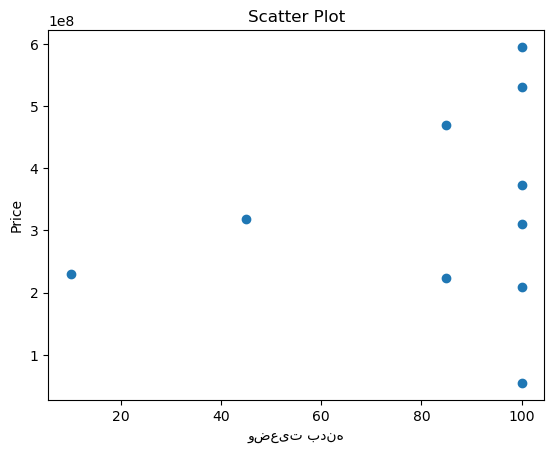

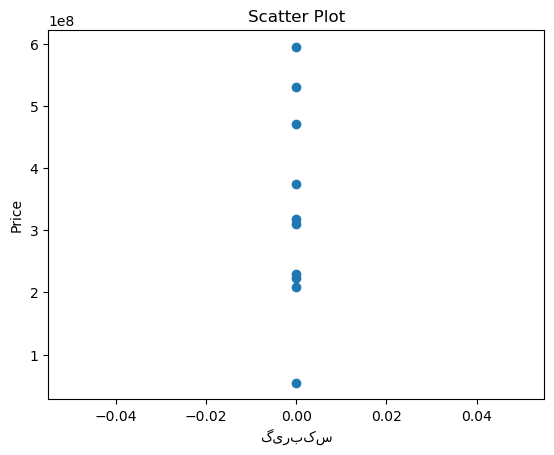

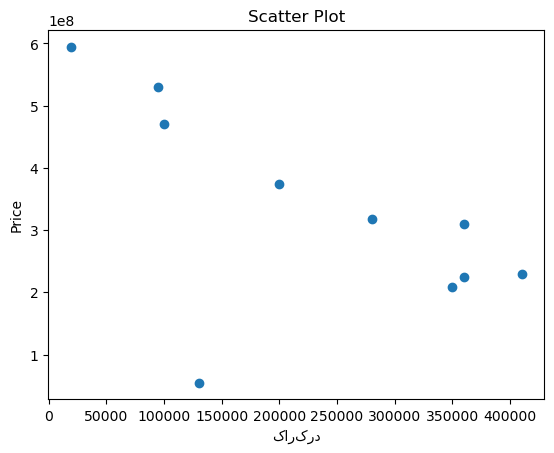

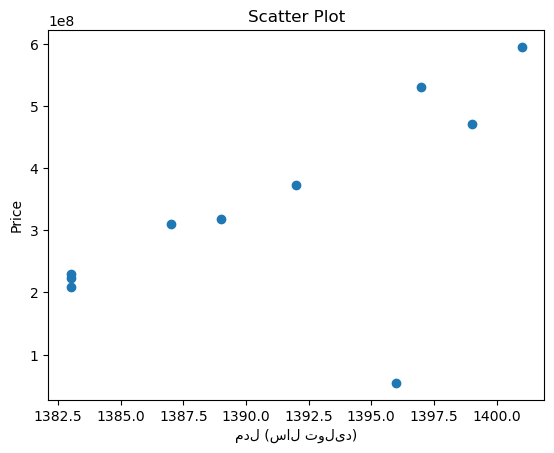

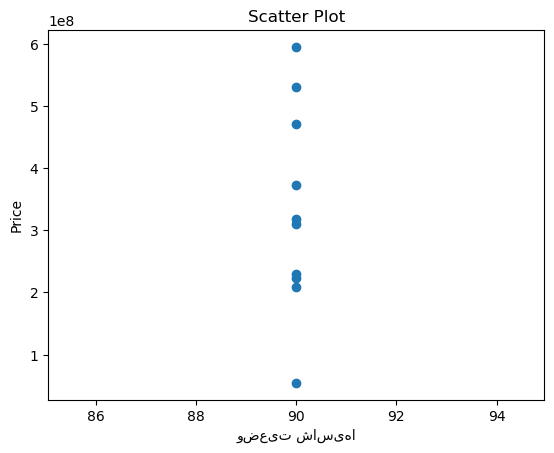

In [15]:
import matplotlib.pyplot as plt

ImportantColumn = ['colume_4', 'colume_6', 'colume_10', 'colume_11', 'colume_3']
for col in ImportantColumn:
    plt.scatter(df[col], df['price'])
    plt.title("Scatter Plot")
    plt.xlabel(token[col])
    plt.ylabel('Price')
    plt.show()

In [ ]:
df = df[['colume_4', 'colume_10', 'colume_11', 'price', 'url']]

<AxesSubplot:ylabel='colume_4'>

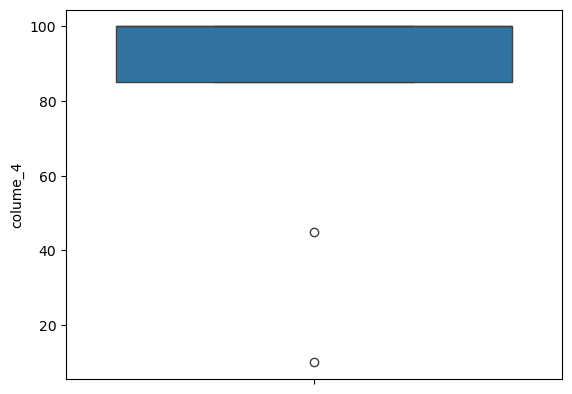

In [22]:
import seaborn as sns

sns.boxplot(df['colume_4'])

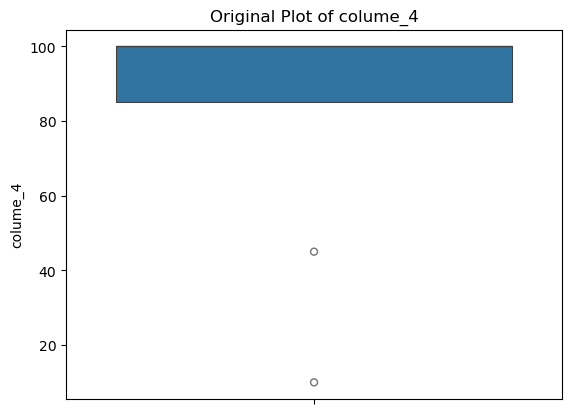

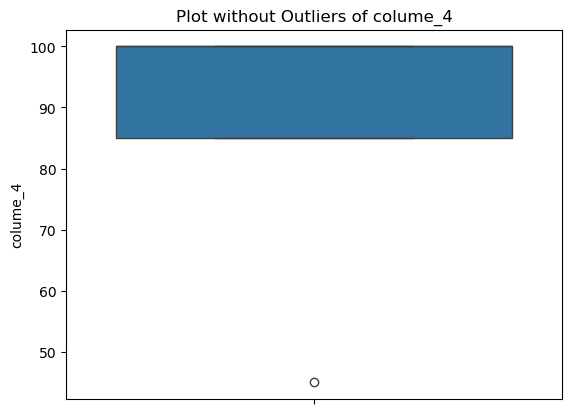

In [29]:
from MainProject.PreprocessingData import Preprocess

dectect_outlier = Preprocess()

df_2 = dectect_outlier.RemoveOutliers(df, 'colume_4', 20)


In [30]:
df_2

,colume_4,colume_10,colume_11,price,url
0,45,280000,1389,318000000.0,https://divar.ir/v/پژو-206-sd-۲۰۶-موتور-و-شاسی...
1,100,130000,1396,55000000.0,https://divar.ir/v/پژو-206-sd-v8-مدل-۱۳۹۶/gZEE...
2,100,200000,1392,373500000.0,https://divar.ir/v/پژو-206-sd-v8-مدل-۱۳۹۲-tu5/...
3,85,100000,1399,470000000.0,https://divar.ir/v/پژو-206-تیپ-۲-مدل-۱۳۹۹/gZD8...
4,85,360000,1383,224000000.0,https://divar.ir/v/خودرو-۲۰۶-تیپ-۳/gZD8vmhU
5,100,350000,1383,209000000.0,https://divar.ir/v/پژو-206-تیپ-۲-مدل-۱۳۸۳/gZD8...
6,100,95000,1397,530000000.0,https://divar.ir/v/پژو-206-sd-v8-مدل-۱۳۹۷/gZDw...
7,100,360000,1387,310000000.0,https://divar.ir/v/پژو-206-تیپ-۲-مدل-۱۳۸۷/gZDw...
9,100,19000,1401,595000000.0,https://divar.ir/v/پژو-206-تیپ-۲-مدل-۱۴۰۱/gZD0...


In [18]:
token

{'colume_3': 'وضعیت شاسی\u200cها',
 'colume_4': 'وضعیت بدنه',
 'colume_5': 'مهلت بیمهٔ شخص ثالث',
 'colume_6': 'گیربکس',
 'colume_10': 'کارکرد',
 'colume_11': 'مدل (سال تولید)'}

In [31]:
# Save data

df_2.to_csv("Cars.csv")